# Необходимые задачи
* Использование PCA
* изучить Streamlit


Да, я реализовал pet-проект для выявления аномалий в данных о транзакциях, используя алгоритмы машинного обучения.

Цели проекта:

    Разработать модель для обнаружения подозрительных транзакций в финансовых данных.
    Изучить подходы к работе с несбалансированными данными.
    Улучшить навыки визуализации результатов анализа и построения автоматизированных пайплайнов.

Описание проекта:
В проекте я работал с набором данных, содержащим записи о транзакциях, включая информацию о сумме, времени, типе операции и метке "аномалия" для части данных.
Я использовал алгоритм Isolation Forest для автоматического выявления аномалий. Перед этим я провёл очистку и масштабирование данных, а также использовал PCA для уменьшения размерности и визуализации результатов.

Результат проекта:
Модель успешно определяла аномалии, достигая 95% точности в тестовом наборе. Я также создал дашборд на основе __Streamlit__, который позволял загружать новые данные и визуализировать подозрительные транзакции.

Практическая направленность:
Проект продемонстрировал, как алгоритмы выявления аномалий могут быть использованы для борьбы с мошенничеством в реальных финансовых системах. Его можно масштабировать для обработки больших данных и интегрировать в системы мониторинга.

# Поиск аномалий в банковских транзакциях
Необходимо настроить систему распознавания мошеннических транзакций по кредитным картам, чтобы с клиентов не взималась плата за товары, которые они не покупали. Исходные данные анонимных транзакций по кредитным картам на https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv.

## Подключение библиотек

In [13]:
# Импорт основных библиотек
import numpy as np
import pandas as pd

# Импорт библиотек машинного обучения
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Импорт библиотеки построения диаграмм и графиков
from matplotlib import pyplot as plt
import seaborn as sns

# Указание режима отображения диаграмм
%matplotlib inline

# Настройка среды Pandas
pd.set_option("display.max_columns", 200)

# Для воспроизводимости зафиксируем начальное значение генератора случайных чисел
np.random.seed(42)

# Число отображаемых признаков в матрице рассеивания
NUM_FEATURES = 8

## Загрузка исходных данных

In [14]:
# Загрузка исходных данных по банковским транзакциям
transaction_df = pd.read_csv('creditcard.csv')

# Вывод загруженных данных
transaction_df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

In [15]:
# Указание удобных наименований признаков
transaction_df.columns = transaction_df.columns.str.lower()


## Разведочный анализ

In [16]:
# Сводная информация о структуре исходных данных
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

In [17]:
# Вывод основных статистик
transaction_df.describe()

time            v1            v2            v3            v4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 v5            v6            v7            v8            v9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

                v10           v11           v12           v13           v14  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   2.239053e-15  1.673327e-15 -1.247012e-15  8.190001e-16  1.207294e-15   
std    1.088850e+00  1.020713e+00  9.992014e-01  9.952742e-01  9.585956e-01   
min   -2.458826e+01 -4.797473e+00 -1.868371e+01 -5.791881e+00 -1.921433e+01   
25%   -5.354257e-01 -7.624942e-01 -4.055715e-01 -6.485393e-01 -4.255740e-01   
50%   -9.291738e-02 -3.275735e-02  1.400326e-01 -1.356806e-02  5.060132e-02   
75%    4.539234e-01  7.395934e-01  6.182380e-01  6.625050e-01  4.931498e-01   
max    2.374514e+01  1.201891e+01  7.848392e+00  7.126883e+00  1.052677e+01   

                v15           v16           v17           v18           v19  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   4.887456e-15  1.437716e-15 -3.772171e-16  9.564149e-16  1.039917e-15   
std    9.153160e-01  8.762529e-01  8.493371e-01  8.381762e-01  8.140405e-01   
min   -4.498945e+00 -1.412985e+01 -2.516280e+01 -9.498746e+00 -7.213527e+00   
25%   -5.828843e-01 -4.680368e-01 -4.837483e-01 -4.988498e-01 -4.562989e-01   
50%    4.807155e-02  6.641332e-02 -6.567575e-02 -3.636312e-03  3.734823e-03   
75%    6.488208e-01  5.232963e-01  3.996750e-01  5.008067e-01  4.589494e-01   
max    8.877742e+00  1.731511e+01  9.253526e+00  5.041069e+00  5.591971e+00   

                v20           v21           v22           v23           v24  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   6.406204e-16  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    7.709250e-01  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min   -5.449772e+01 -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%   -2.117214e-01 -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%   -6.248109e-02 -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    1.330408e-01  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    3.942090e+01  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                v25           v26           v27           v28         amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02

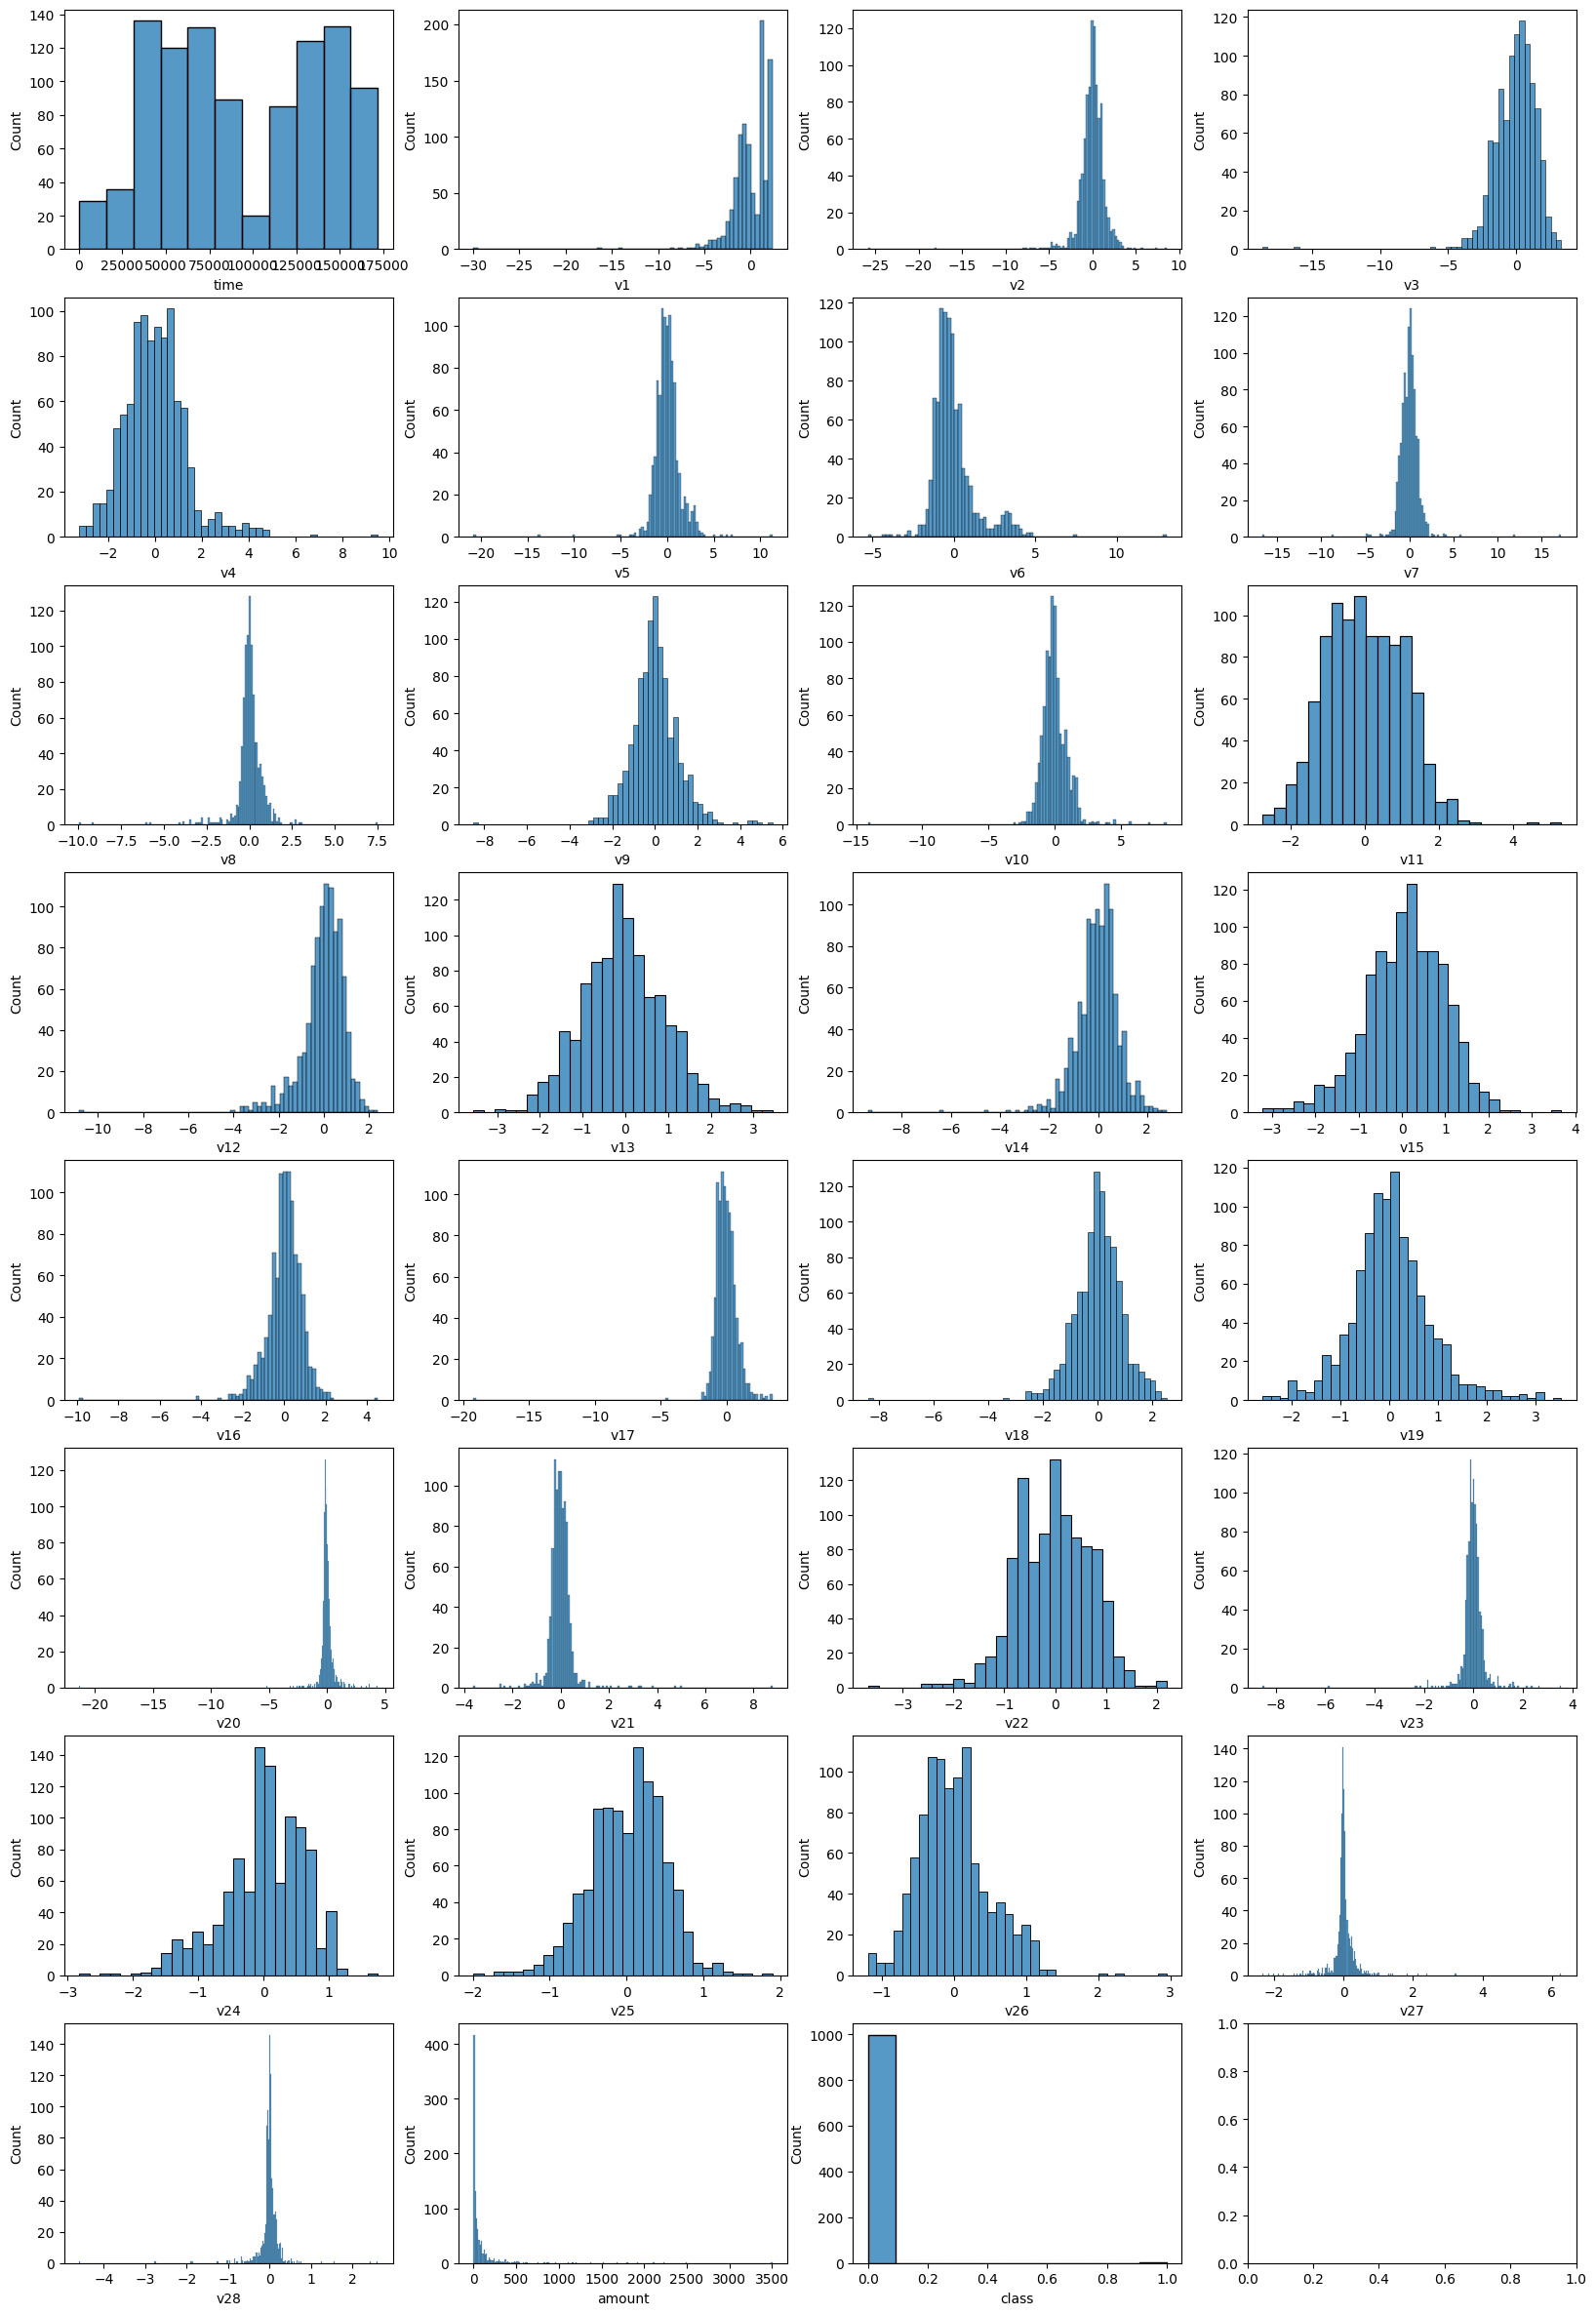

In [18]:
# Определение основных объектов диаграмм
fig, axes = plt.subplots(8, 4, figsize=(20, 30))

# Построение гистограмм признаков
for ax, column in zip(axes.flat, transaction_df.columns):
    sns.histplot(transaction_df.sample(n=1000, random_state=42)[column], ax=ax, )

# Вывод диаграммы
plt.show()


Используя матрицу корреляции оценим сильные и слабые связи между признаками. Проанализируем сильные и слабые признаки по отдельности.


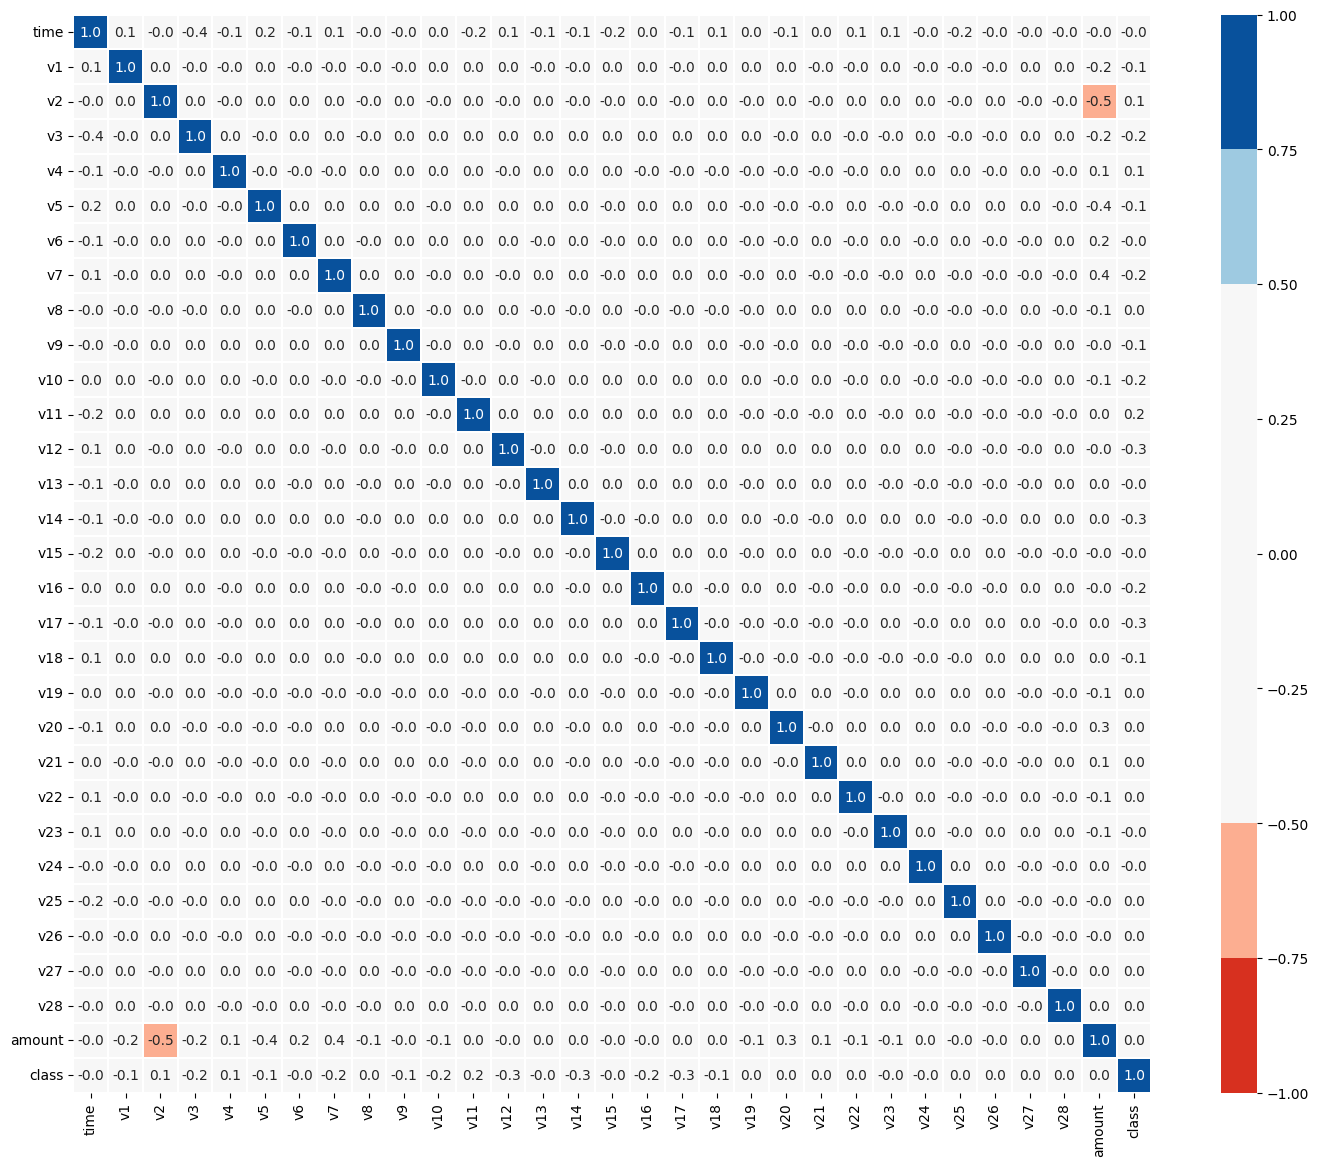

In [19]:
# Создание цветовой карты для подсвечивания сильных связей
color_map = sns.color_palette(['#d7301f', '#fcae91', '#f7f7f7', '#f7f7f7', '#f7f7f7', '#f7f7f7', '#9ecae1', '#08519c'])

plt.figure(figsize=(18, 14))

# Вывод матрицы корреляции для оценки степени линейной зависимости между признаками
sns.heatmap(
    transaction_df.corr(), cmap=color_map, square=True, vmin=-1, vmax=1, center= 0, annot=True,
    linewidths=0.1, fmt='.1f', cbar_kws=dict(ticks=np.arange(-1.0, 1.1, 0.25), aspect=30)
)

plt.show()


Для признаков с сильными связями выведем парное отношение и их распределение.

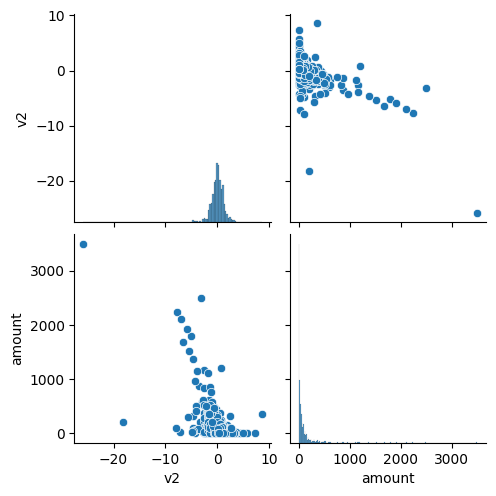

In [20]:
# Формирование списка признаков с сильными связями
corr_matrix = np.abs(transaction_df.corr())
strong_features = [column for column in corr_matrix.columns if any((corr_matrix[column] > 0.5) & (corr_matrix[column] != 1))]

# Отображение парных отношений признаков и их распределение
sns.pairplot(transaction_df.sample(n=1000, random_state=42)[strong_features], diag_kind='hist')

# Вывод диаграммы
plt.show()


Для признаков со слабыми связями матрицу рассеивания отобразим только для небольшой части, поскольку процесс построения парных отношений признаков и их распределений ресурсоемкий.

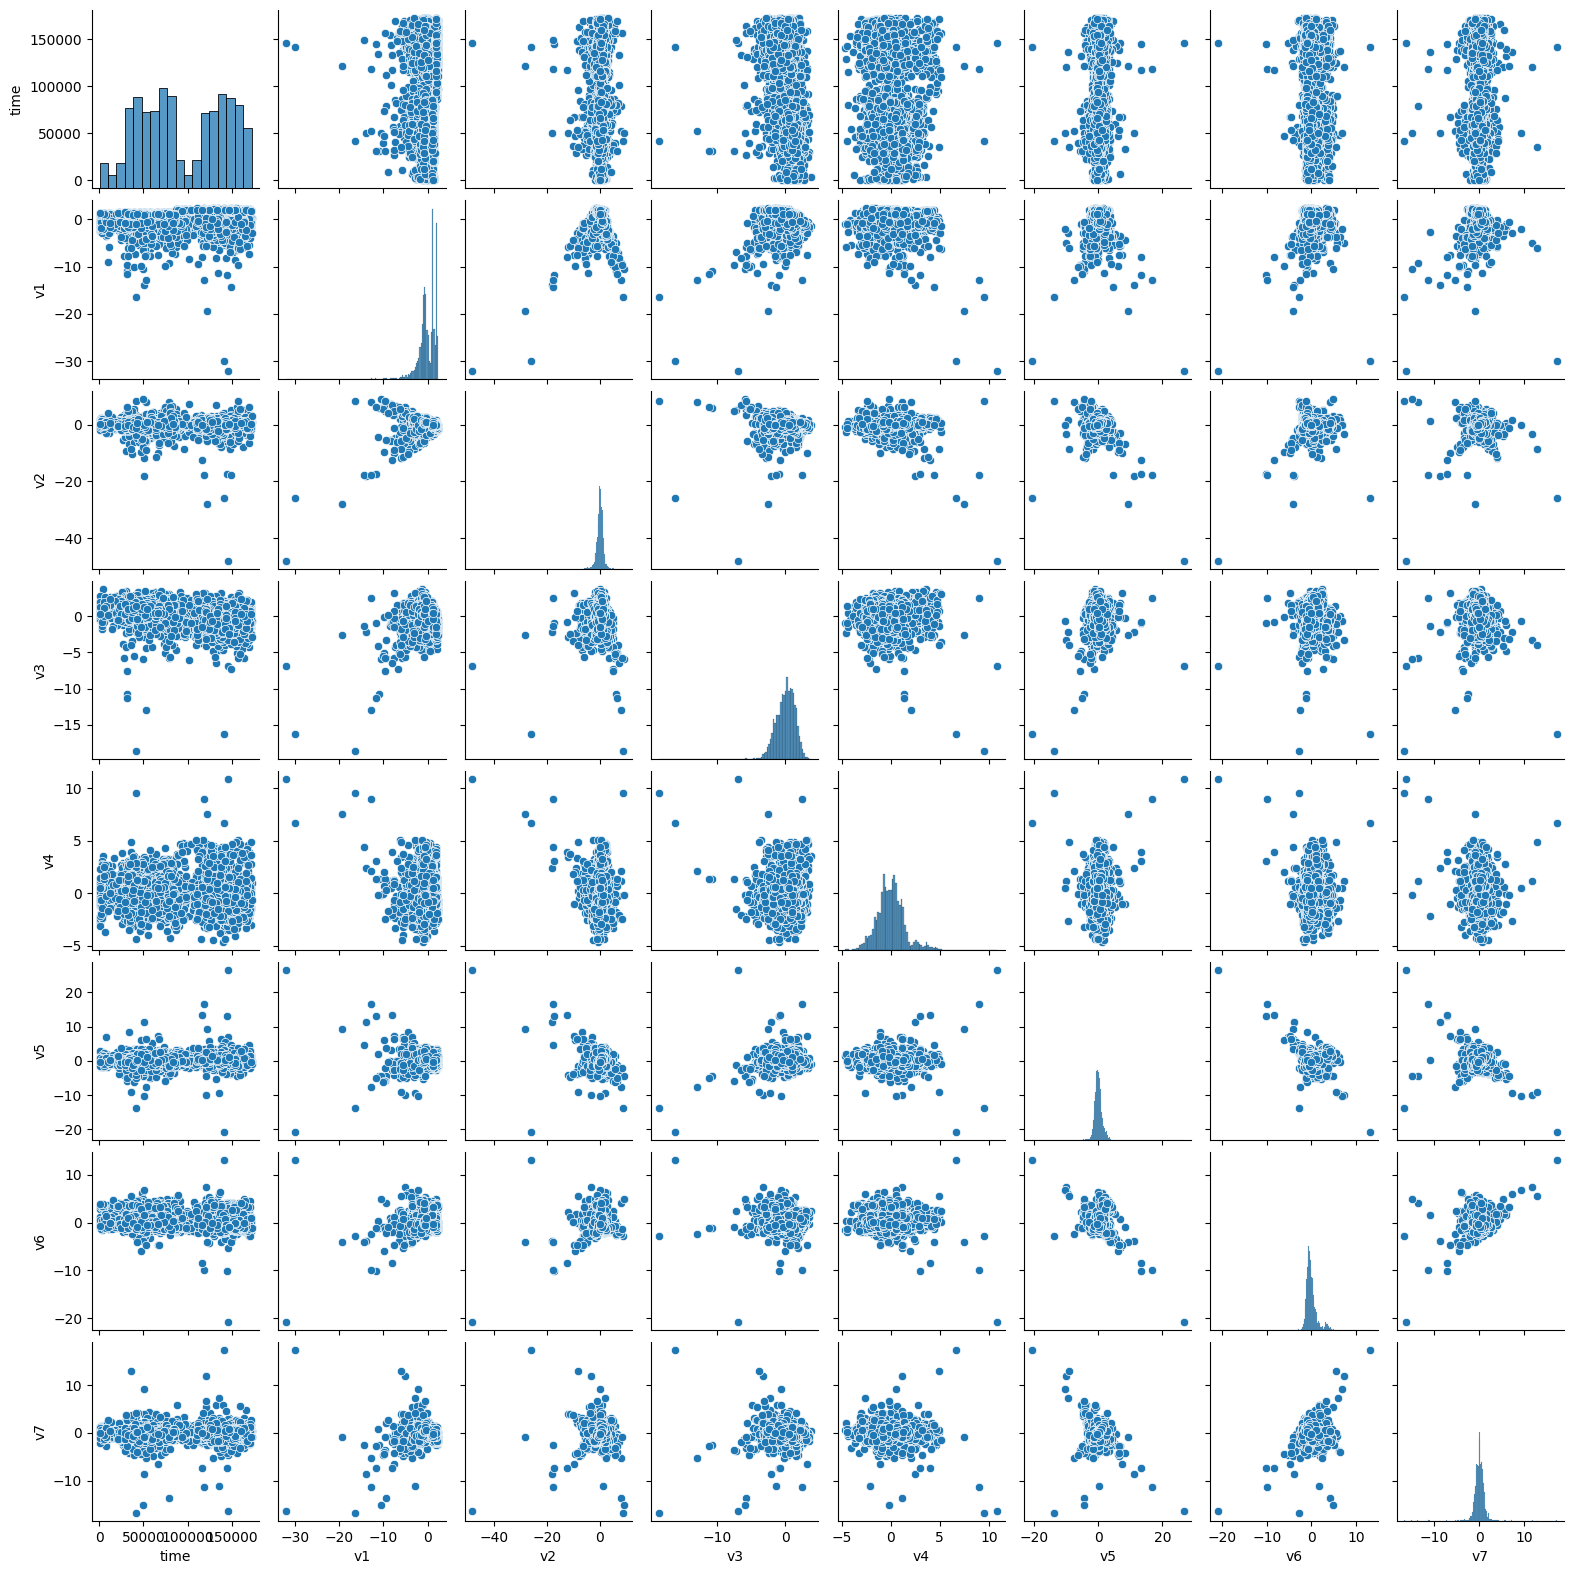

In [21]:
# Формирование списка признаков со слабыми связями
other_features = corr_matrix[~corr_matrix.columns.isin(strong_features)].columns[:-1]

# Отображение парных отношений признаков и их распределение
sns.pairplot(transaction_df.sample(n=5000)[other_features[:NUM_FEATURES]], diag_kind='hist', height=2)

# Вывод диаграммы
plt.show()


## Предобработка данных
Приведем признаки к одному масштабу, поскольку не все алгоритмы машинного обучения могут хорошо работать с данными из разного диапазона. Выполним масштабирование признаков в диапазоне от 0 до 1.


In [22]:
# Нормализация значений признаков
X_data = MinMaxScaler().fit_transform(transaction_df.iloc[:, :-1])
Y_data = transaction_df.iloc[:, -1]


## Построение моделей
Поскольку количество наблюдений в исходных данных более 200 тысяч, для моделирования и поиска выбросов возьмем только их малую часть. Предполагаем, что полученная случайная выборка является репрезентативной выборкой для исходных данных.


In [23]:
# Формирование стратифицированной выборки из исходных данных
X_samples, _, Y_samples, _ = train_test_split(X_data, Y_data, train_size=0.02, stratify=Y_data, random_state=42)

# Вывод доли аномалий от общего числа транзакций
print('Процент аномальных транзакций: {:.2%}'.format(Y_data.mean()))
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))


Процент аномальных транзакций: 0.17%
Процент аномальных транзакций в выборке: 0.18%


### Правило 3-х сигм


In [24]:
# Формирование матрицы выбросов
sigma_outliers = []
for i in range(3, 6):
    up_bound = X_samples.mean(axis=0) + i * X_samples.std(axis=0)
    low_bound = X_samples.mean(axis=0) - i * X_samples.std(axis=0)
    sigma_outliers.append(np.where((X_samples < low_bound) | (X_samples > up_bound), 1, 0).any(axis=1).astype('int8'))

# Подсчет количества и процента выбросов для разных сигм
sum_list = np.array(sigma_outliers).sum(axis=1)
mean_list = np.array(sigma_outliers).mean(axis=1)

# Сохраняем значения для сигмы с наименьшим процентом выбросов
sigma_outliers = np.array(sigma_outliers)[sum_list.argmin()]

# Вывод информации по аномальным транзакциям и выбросам
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))
print('-----------------------------------------------')
print('Количество выбросов в выборке для {} сигм: {}'.format(sum_list.argmin() + 3, sum_list.min()))
print('Процент выбросов в выборке для {} сигм: {:.2%}'.format(mean_list.argmin() + 3, mean_list.min()))


Процент аномальных транзакций в выборке: 0.18%
-----------------------------------------------
Количество выбросов в выборке для 5 сигм: 191
Процент выбросов в выборке для 5 сигм: 3.35%


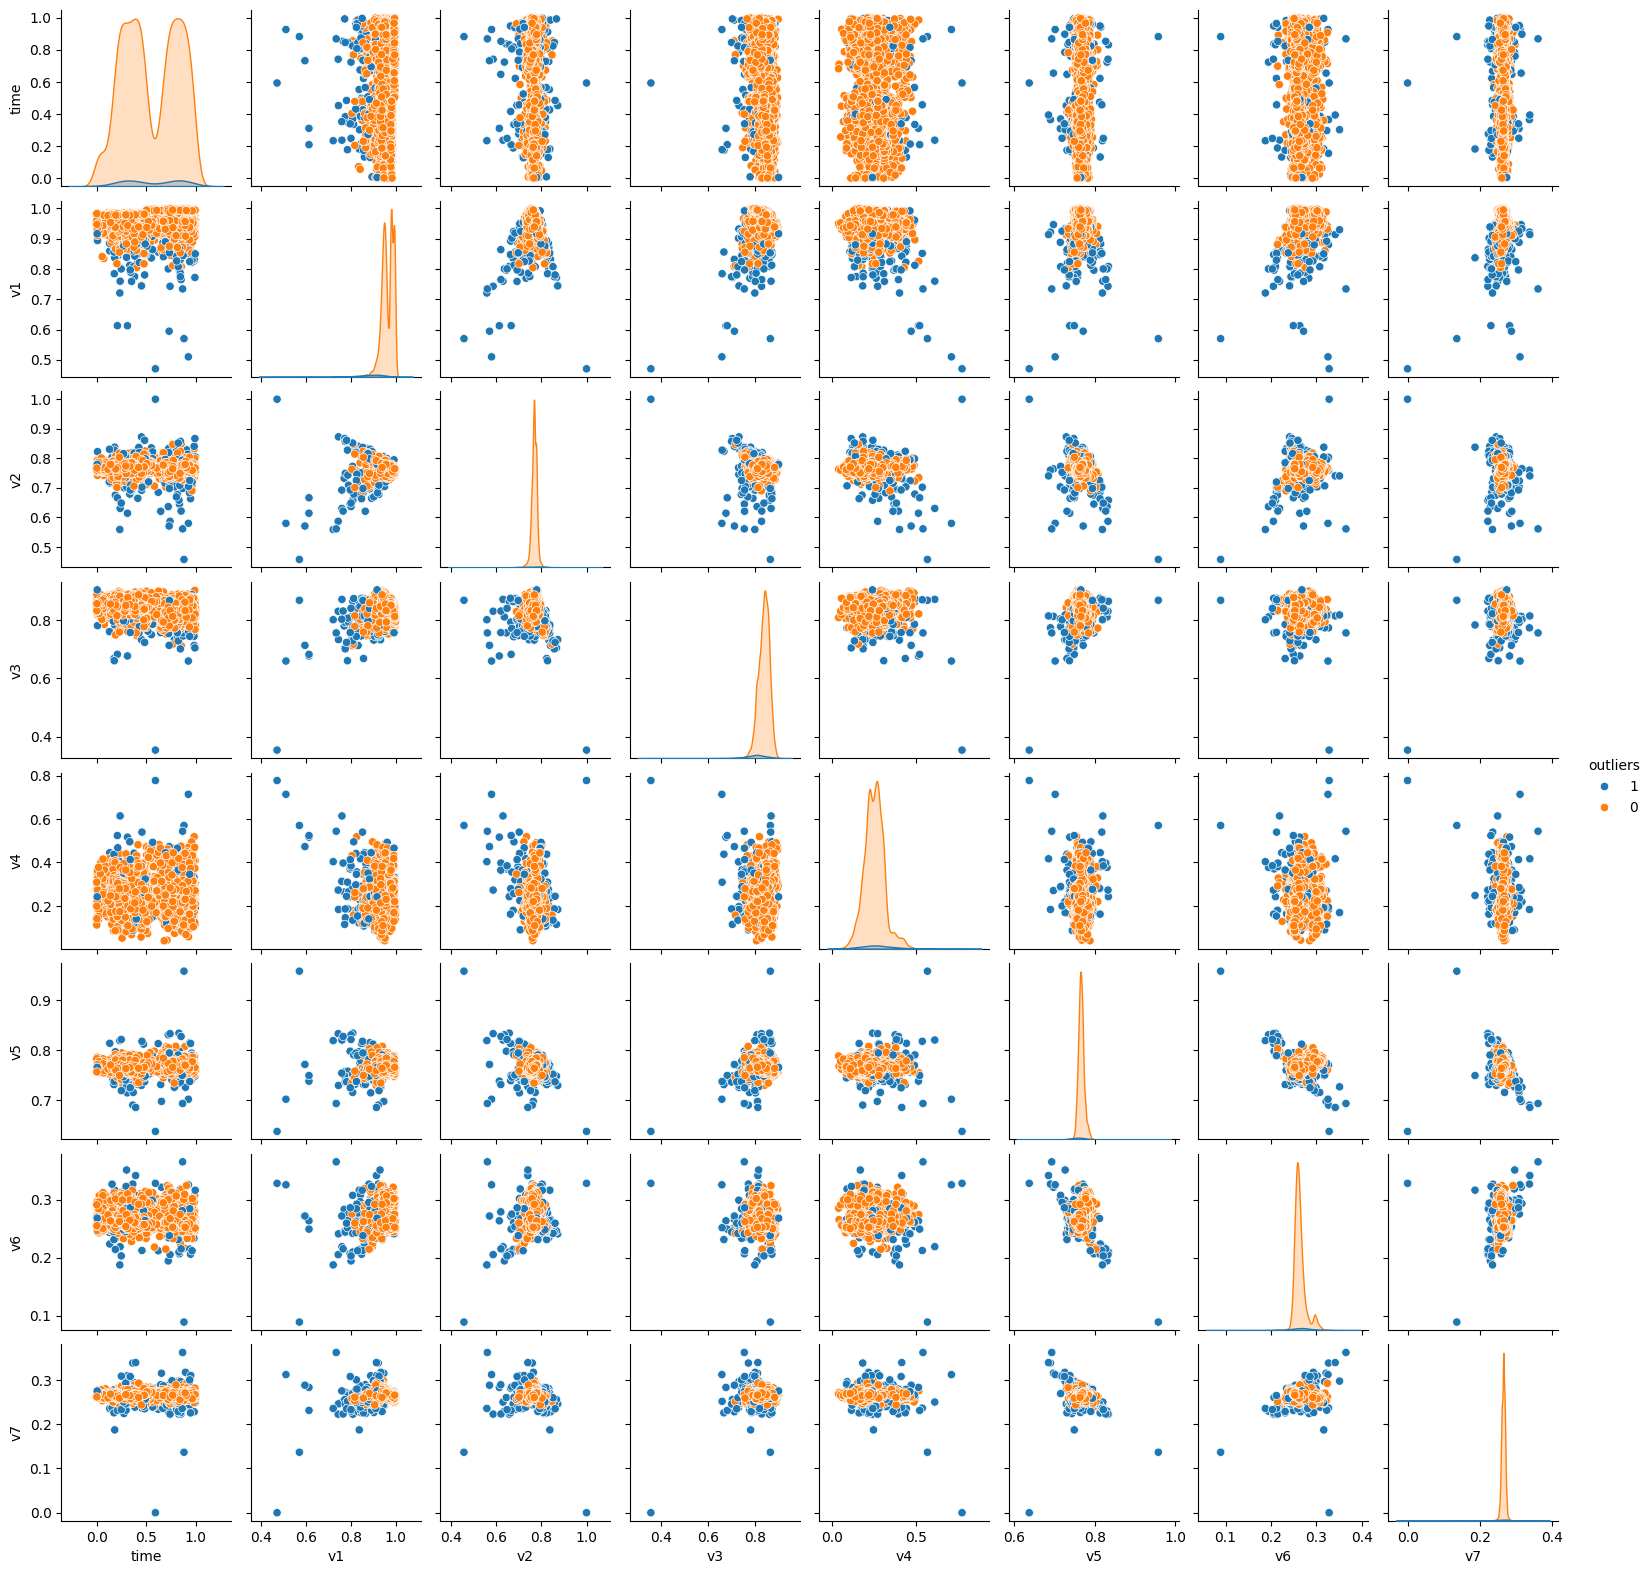

In [25]:
# Формирование матрицы транзакций с атрибутом выброса
tr_matrix = np.hstack((X_samples[:, :NUM_FEATURES], sigma_outliers[:, None]))
tr_df = pd.DataFrame(tr_matrix, columns=[*transaction_df.columns[:NUM_FEATURES], 'outliers'])

# Отображение парных отношений признаков и их распределение
sns.pairplot(tr_df, hue='outliers', hue_order=[1, 0], height=2)

plt.show()

### Межквартильное отклонение


In [26]:
# Формирование матрицы выбросов
quantile_outliers = []
for i in range(3, 11):
    up_bound, low_bound = np.quantile(X_samples, [0.75, 0.25], axis=0)
    up_bound, low_bound = [up_bound, low_bound] + np.array([[i], [-i]]) * (up_bound - low_bound)
    quantile_outliers.append(np.where((X_samples < low_bound) | (X_samples > up_bound), 1, 0).any(axis=1).astype('int8'))

# Подсчет количества и процента выбросов для разного межквартильного расстояния
sum_list = np.array(quantile_outliers).sum(axis=1)
mean_list = np.array(quantile_outliers).mean(axis=1)

# Сохраняем значения для межквартильного расстояния с наименьшим процентом выбросов
quantile_outliers = np.array(quantile_outliers)[sum_list.argmin()]

# Вывод информации по аномальным транзакциям и выбросам
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))
print('-----------------------------------------------')
print('Количество выбросов в выборке для {} IRQ: {}'.format(sum_list.argmin() + 3, sum_list.min()))
print('Процент выбросов в выборке для {} IRQ: {:.2%}'.format(mean_list.argmin() + 3, mean_list.min()))


Процент аномальных транзакций в выборке: 0.18%
-----------------------------------------------
Количество выбросов в выборке для 10 IRQ: 224
Процент выбросов в выборке для 10 IRQ: 3.93%


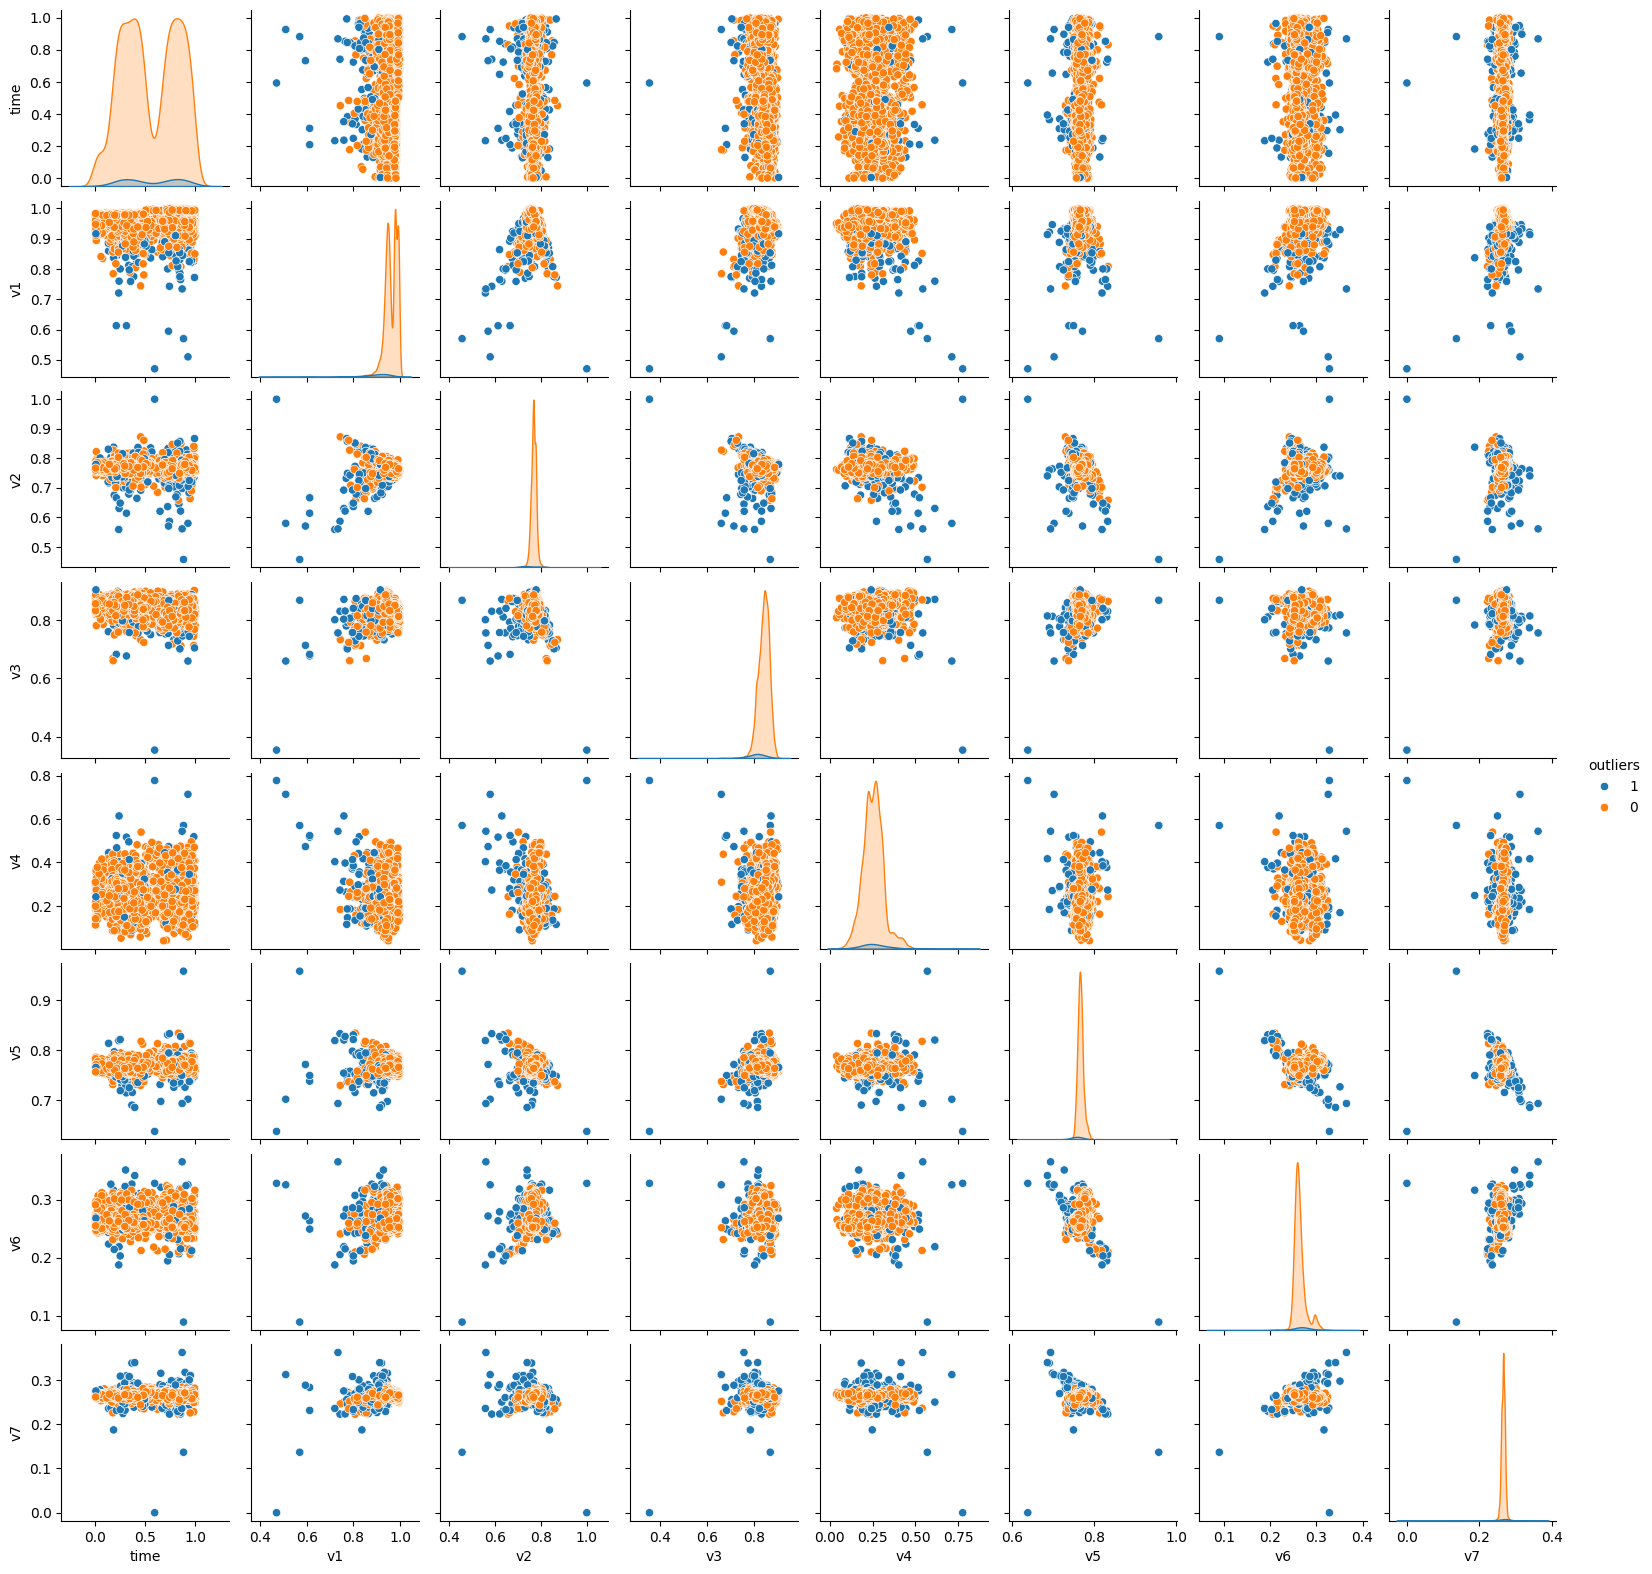

In [27]:
# Формирование матрицы транзакций с атрибутом выброса
tr_matrix = np.hstack((X_samples[:, :NUM_FEATURES], quantile_outliers[:, None]))
tr_df = pd.DataFrame(tr_matrix, columns=[*transaction_df.columns[:NUM_FEATURES], 'outliers'])

# Отображение парных отношений признаков и их распределение
sns.pairplot(tr_df, hue='outliers', hue_order=[1, 0], height=2)

plt.show()

### Метод DBSCAN


d:\Codes\Python\Data\transactions\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Codes\Python\Data\transactions\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


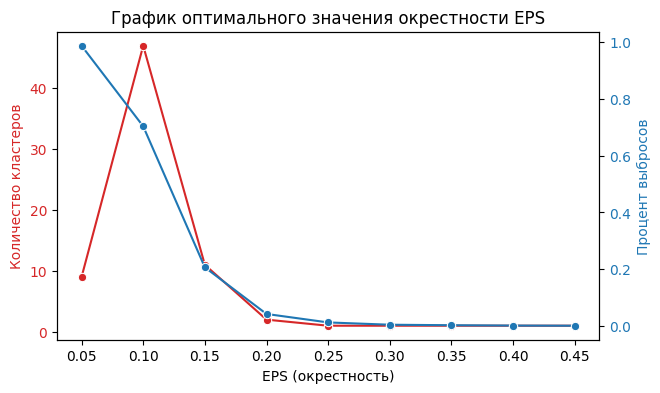

In [28]:
# Определение переменных
num_clusters = []
per_anomalies = []

# Построение модели для поиска оптимального значения окрестности EPS
for i in np.arange(0.05, 0.5, 0.05):
    model = DBSCAN(eps=i, n_jobs=-1).fit(X_samples)
    num_clusters.append(len(np.unique(model.labels_)) - 1)
    per_anomalies.append(np.where(model.labels_==-1, 1, 0).sum() / len(model.labels_))

# Определение основных объектов диаграмм
fig, axes = plt.subplots(1, 1, figsize=(7,4))

# Построение графика зависимости процента выбросов от количества кластеров
sns.lineplot(x=np.arange(0.05, 0.5, 0.05), y=num_clusters, marker='o', ax=axes, color='tab:red')
percent_axes = sns.lineplot(x=np.arange(0.05, 0.5, 0.05), y=per_anomalies, marker='o', ax=axes.twinx(), color='tab:blue')

# Вывод заголовка диаграмм и подписей осей
axes.set(title='График оптимального значения окрестности EPS', xlabel='EPS (окрестность)')
axes.set_ylabel('Количество кластеров', color='tab:red')
axes.tick_params(axis='y', labelcolor='tab:red')
percent_axes.set_ylabel('Процент выбросов', color='tab:blue')
percent_axes.tick_params(axis='y', labelcolor='tab:blue')

# Вывод диаграмм
plt.show()


In [29]:
# Формирование матрицы выбросов
model = DBSCAN(eps=0.3, n_jobs=-1).fit(X_samples)
dbscan_outliers = np.where(model.labels_==-1, 1, 0)

# Вывод информации по аномальным транзакциям и выбросам
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))
print('-----------------------------------------------')
print('Количество выбросов в выборке: {}'.format(dbscan_outliers.sum()))
print('Процент выбросов в выборке: {:.2%}'.format(dbscan_outliers.mean()))


Процент аномальных транзакций в выборке: 0.18%
-----------------------------------------------
Количество выбросов в выборке: 25
Процент выбросов в выборке: 0.44%


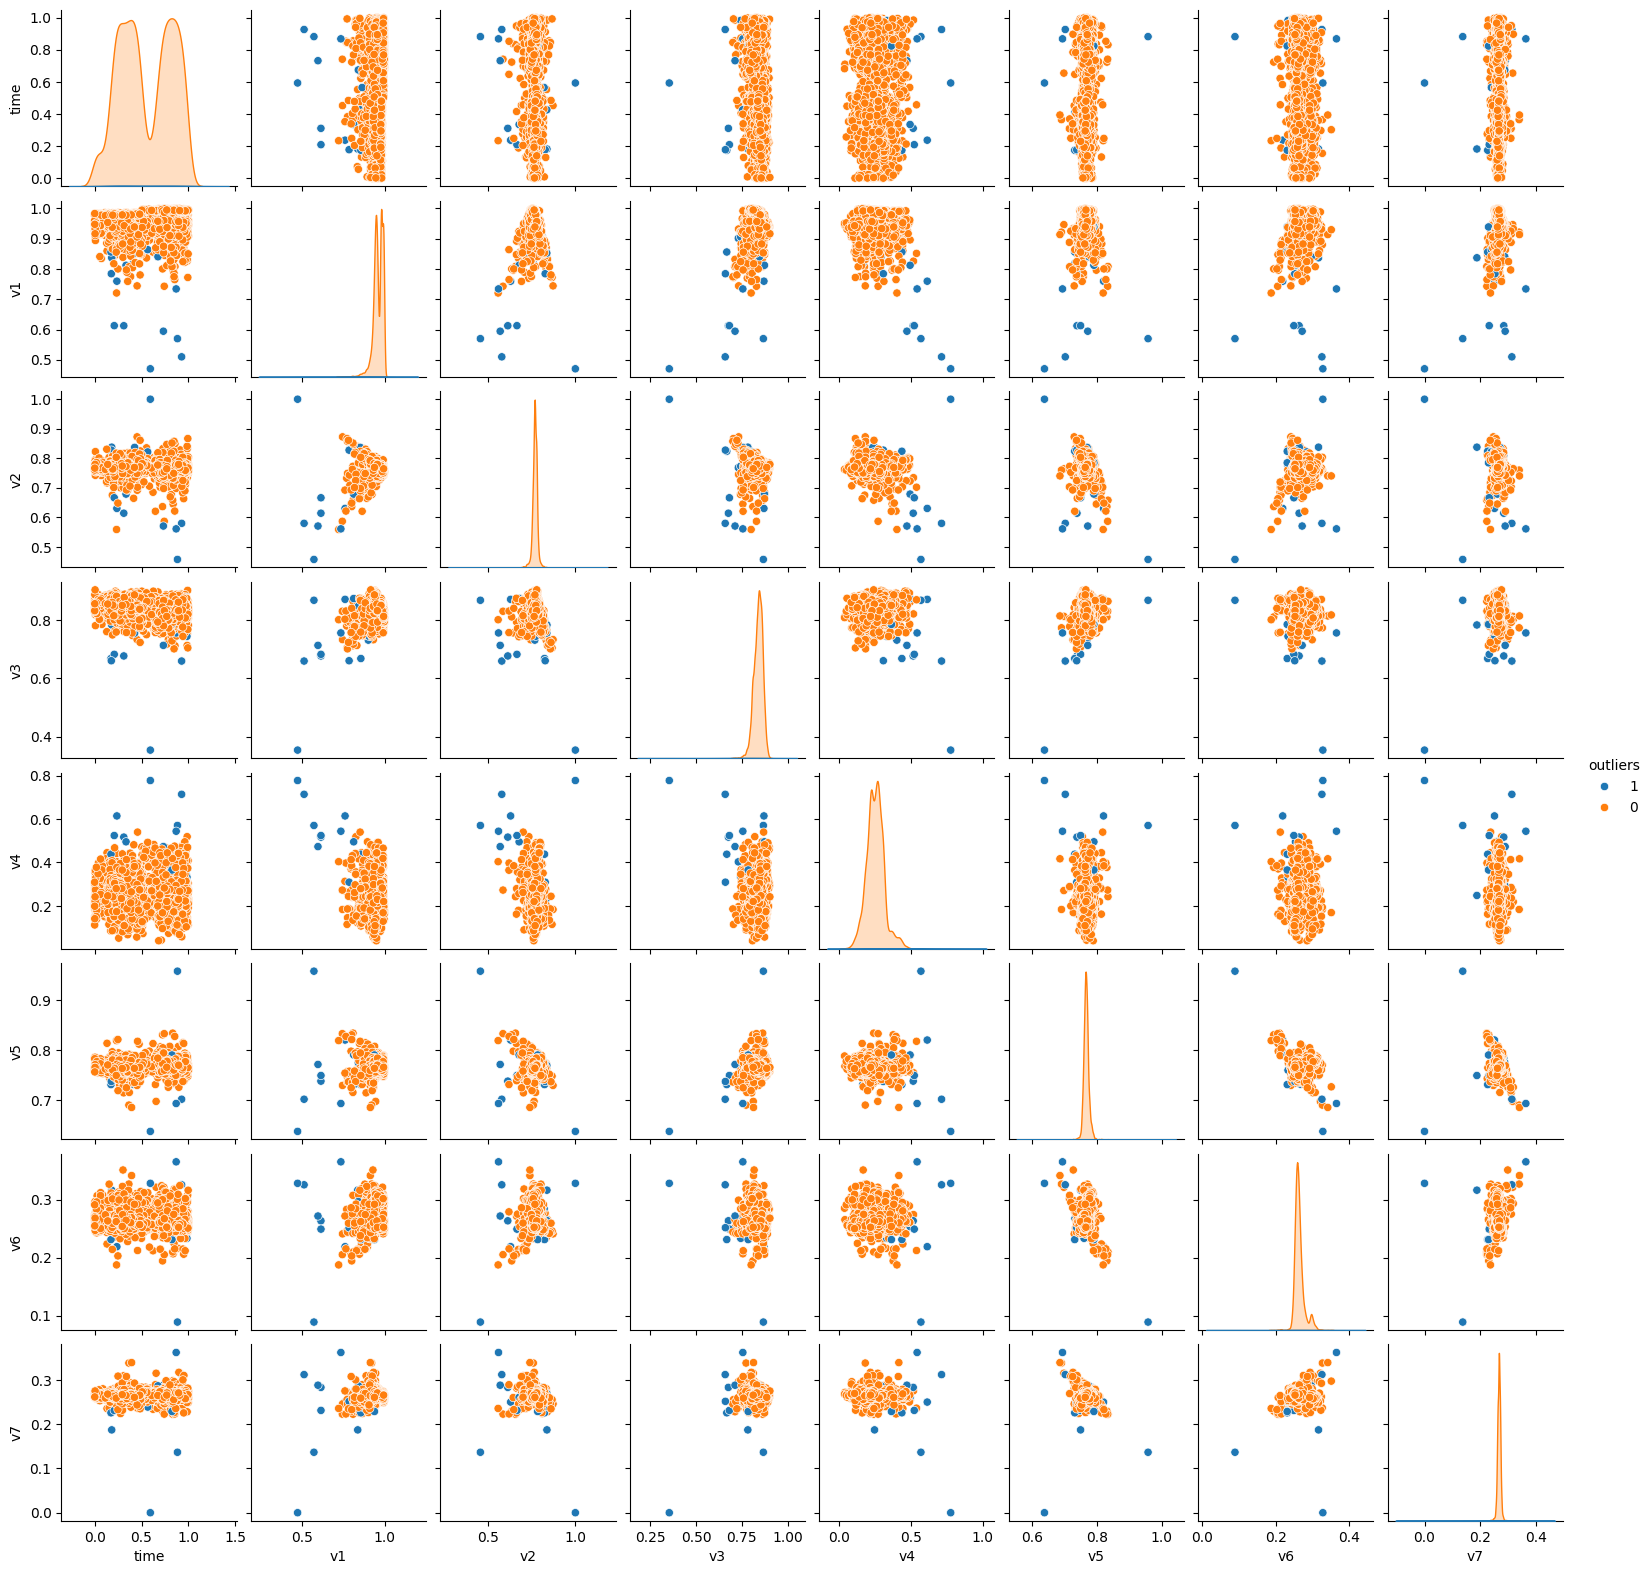

In [30]:
# Формирование матрицы транзакций с атрибутом выброса
tr_matrix = np.hstack((X_samples[:, :NUM_FEATURES], dbscan_outliers[:, None]))
tr_df = pd.DataFrame(tr_matrix, columns=[*transaction_df.columns[:NUM_FEATURES], 'outliers'])

# Отображение парных отношений признаков и их распределение
sns.pairplot(tr_df, hue='outliers', hue_order=[1, 0], height=2)

# Вывод диаграммы
plt.show()


### Метод One-Class SVM


In [31]:
# Формирование матрицы выбросов
svm_outliers = []
for i in np.arange(0.01, 0.1, 0.02):
    model = OneClassSVM(nu=i, gamma='auto').fit(X_samples)
    svm_outliers.append(np.where(model.predict(X_samples)==-1, 1, 0))

# Подсчет количества и процента выбросов для разных моделей
sum_list = np.array(svm_outliers).sum(axis=1)
mean_list = np.array(svm_outliers).mean(axis=1)

# Сохраняем значения для модели с наименьшим процентом выбросов
svm_outliers = np.array(svm_outliers)[sum_list.argmin()]

# Вывод информации по аномальным транзакциям и выбросам
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))
print('-----------------------------------------------')
print('Количество выбросов в выборке: {}'.format(sum_list.min()))
print('Процент выбросов в выборке: {:.2%}'.format(mean_list.min()))


Процент аномальных транзакций в выборке: 0.18%
-----------------------------------------------
Количество выбросов в выборке: 55
Процент выбросов в выборке: 0.97%


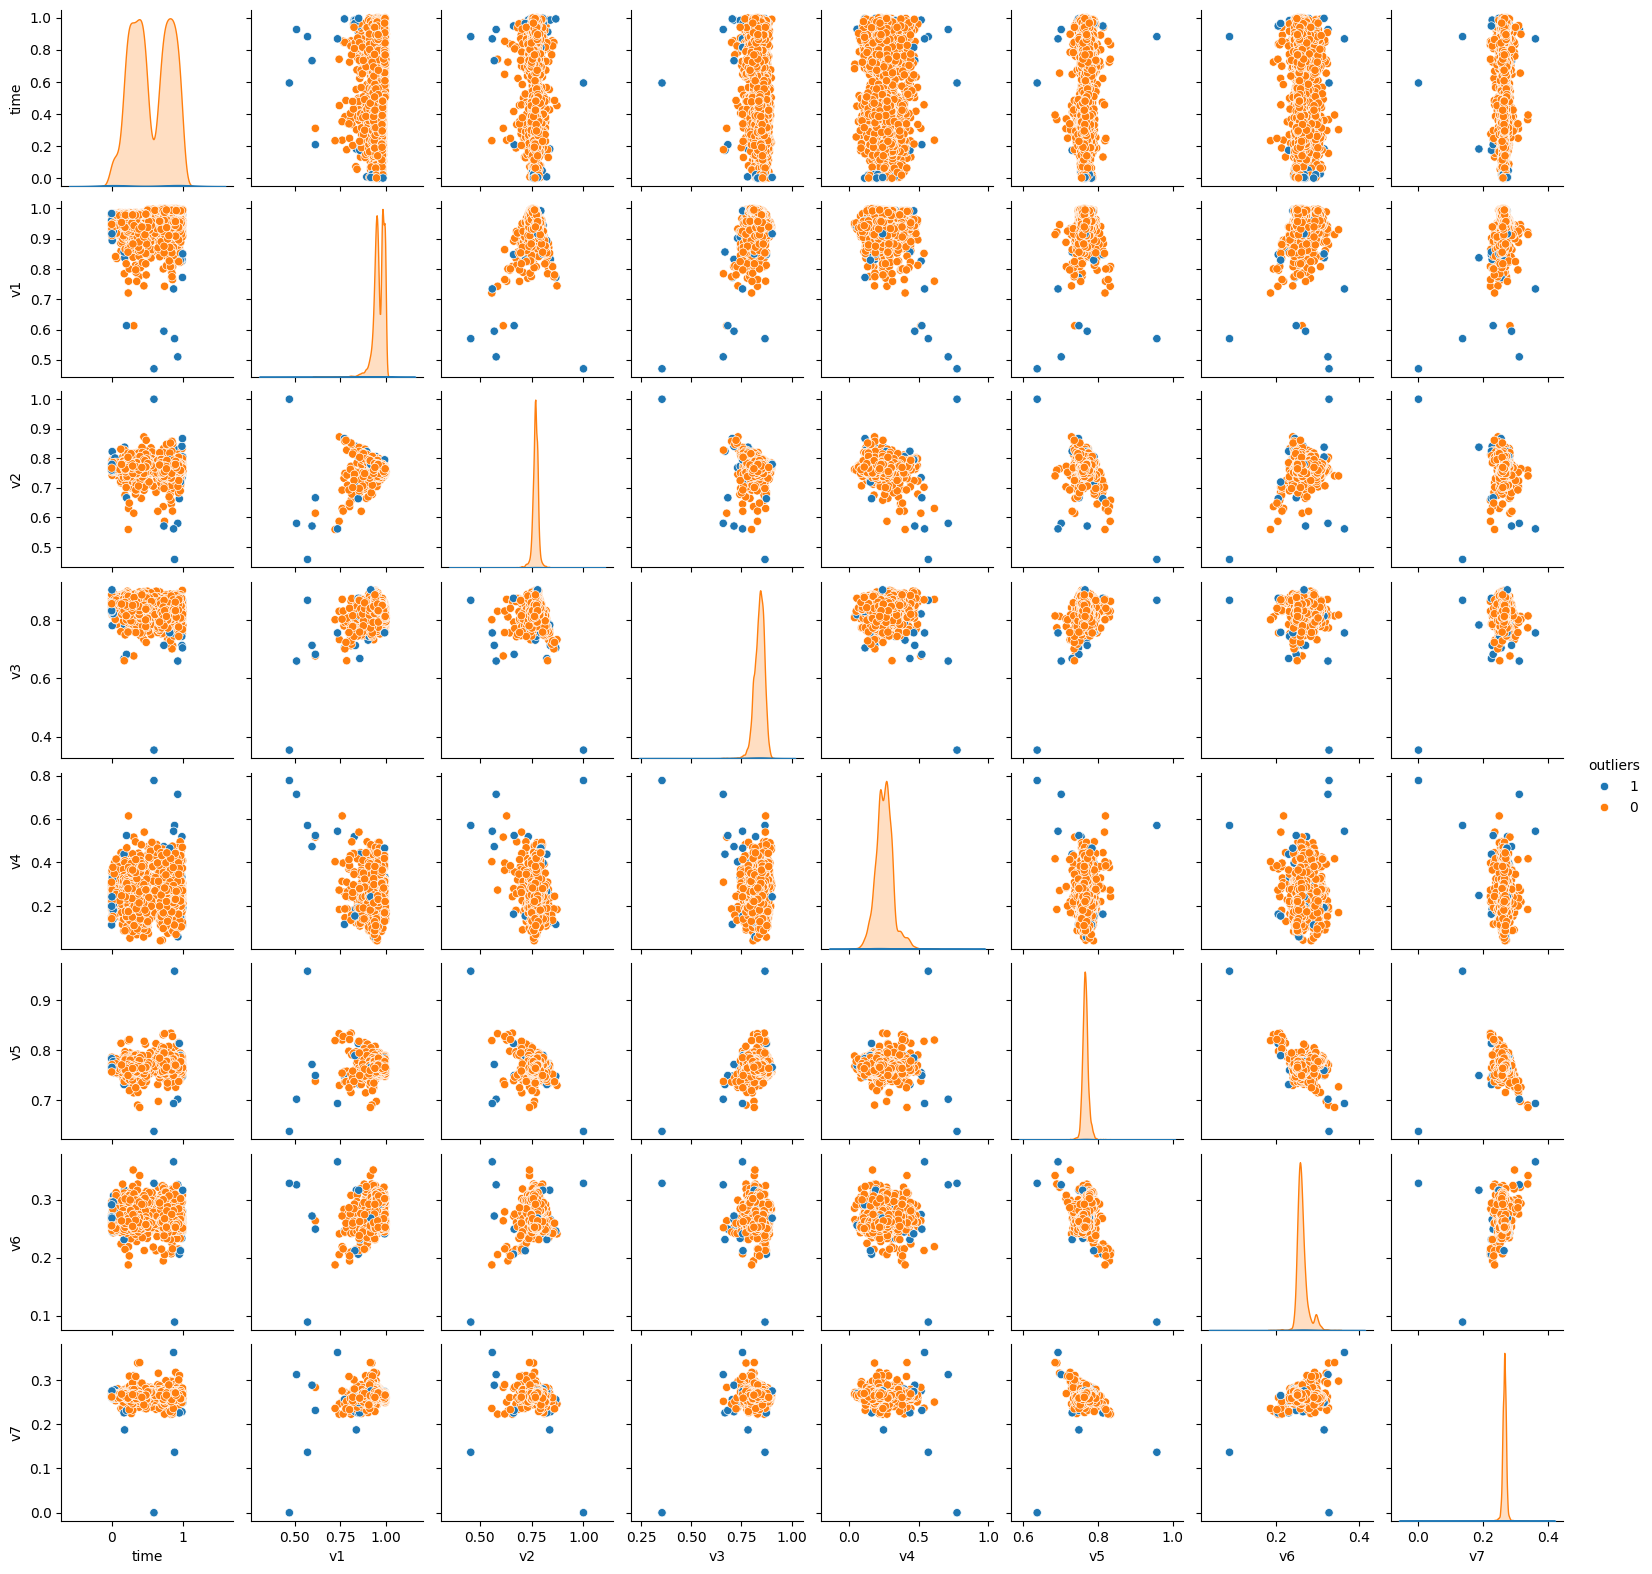

In [32]:
# Формирование матрицы транзакций с атрибутом выброса
tr_matrix = np.hstack((X_samples[:, :NUM_FEATURES], svm_outliers[:, None]))
tr_df = pd.DataFrame(tr_matrix, columns=[*transaction_df.columns[:NUM_FEATURES], 'outliers'])

# Отображение парных отношений признаков и их распределение
sns.pairplot(tr_df, hue='outliers', hue_order=[1, 0], height=2)

# Вывод диаграммы
plt.show()

### Метод Isolation Forest


In [33]:
# Формирование матрицы выбросов
forest_outliers = []
for i in np.arange(0.005, 0.05, 0.005):
    model = IsolationForest(n_jobs=-1, contamination=i, random_state=42).fit(X_samples)
    forest_outliers.append(np.where(model.predict(X_samples)==-1, 1, 0))

# Подсчет количества и процента выбросов для разных моделей
sum_list = np.array(forest_outliers).sum(axis=1)
mean_list = np.array(forest_outliers).mean(axis=1)

# Сохраняем значения для модели с наименьшим процентом выбросов
forest_outliers = np.array(forest_outliers)[sum_list.argmin()]

# Вывод информации по аномальным транзакциям и выбросам
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))
print('-----------------------------------------------')
print('Количество выбросов в выборке: {}'.format(sum_list.min()))
print('Процент выбросов в выборке: {:.2%}'.format(mean_list.min()))


Процент аномальных транзакций в выборке: 0.18%
-----------------------------------------------
Количество выбросов в выборке: 29
Процент выбросов в выборке: 0.51%


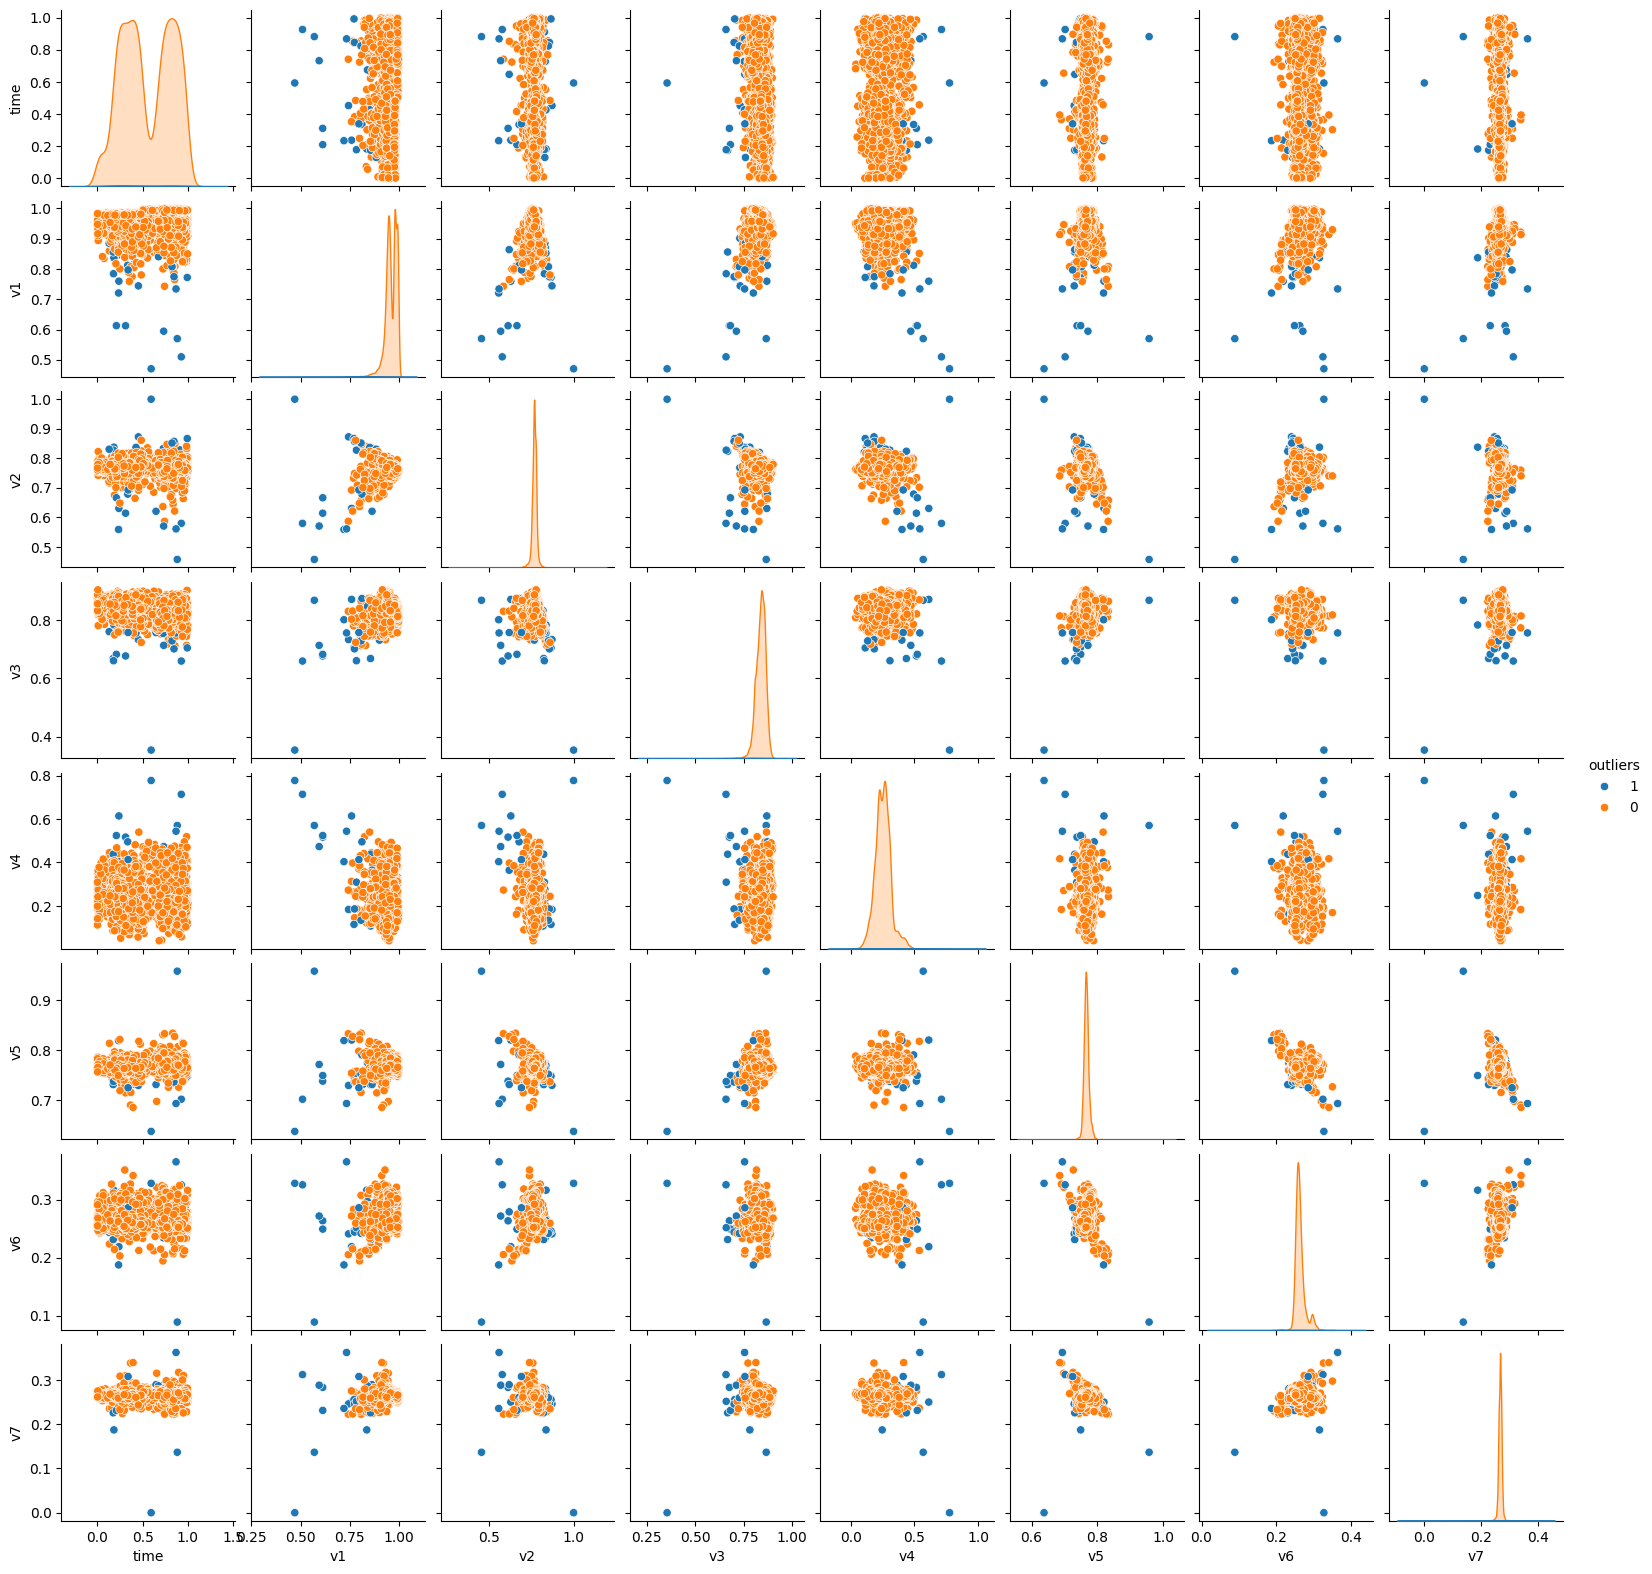

In [34]:
# Формирование матрицы транзакций с атрибутом выброса
tr_matrix = np.hstack((X_samples[:, :NUM_FEATURES], forest_outliers[:, None]))
tr_df = pd.DataFrame(tr_matrix, columns=[*transaction_df.columns[:NUM_FEATURES], 'outliers'])

# Отображение парных отношений признаков и их распределение
sns.pairplot(tr_df, hue='outliers', hue_order=[1, 0], height=2)

# Вывод диаграммы
plt.show()


## Сравнение моделей


In [35]:
# Объединение полученных результатов предсказаний по выбросам
outliers = np.vstack([sigma_outliers, quantile_outliers, dbscan_outliers, svm_outliers, forest_outliers])
titles = ['Правило 3-х сигм', 'Межквартильное отклонение', 'Метод DBSCAN', 'Метод One-Class SVM', 'Метод Isolation Forest']

# Сравнение качества моделей по доле выявленных выбросов
outliers_df = pd.DataFrame(np.round(np.hstack([Y_samples.mean(), outliers.mean(axis=1)])[:, None]*100, 2),
                           columns=['Процент'], index=['По выборке', *titles])
outliers_df


Процент
По выборке                    0.18
Правило 3-х сигм              3.35
Межквартильное отклонение     3.93
Метод DBSCAN                  0.44
Метод One-Class SVM           0.97
Метод Isolation Forest        0.51

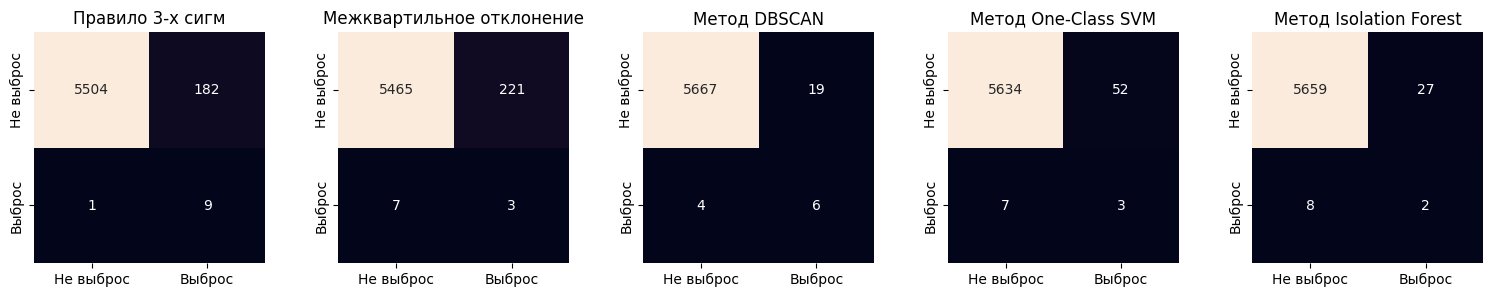

In [36]:
fig, axes = plt.subplots(1, 5, figsize=(19, 3))

# Вывод матриц ошибок для ранее построенных моделей
for i in range(len(outliers)):
    sns.heatmap(confusion_matrix(Y_samples, outliers[i]), fmt='.0f', 
                xticklabels=['Не выброс', 'Выброс'], yticklabels=['Не выброс', 'Выброс'], 
                ax=axes[i], square=True, cbar=False, annot=True)
    axes[i].set_title(titles[i])
    
plt.show()


In [37]:
# Определение переменных
scores = []

# Расчет оценок качества и охвата выбросов моделями
for i in range(len(outliers)):
    scores.append([precision_score(Y_samples, outliers[i]), recall_score(Y_samples, outliers[i]), 
                   f1_score(Y_samples, outliers[i]), roc_auc_score(Y_samples, outliers[i])])

# Вывод точности и охвата прогнозирования моделями выбросов
scores_df = pd.DataFrame(np.array(scores).round(2), 
                         columns=['precision', 'recall', 'f1-score', 'auc-roc'], 
                         index=titles)

print('Таблица оценок точности и охвата определения выбросов в данных')
scores_df


Таблица оценок точности и охвата определения выбросов в данных


precision  recall  f1-score  auc-roc
Правило 3-х сигм                0.05     0.9      0.09     0.93
Межквартильное отклонение       0.01     0.3      0.03     0.63
Метод DBSCAN                    0.24     0.6      0.34     0.80
Метод One-Class SVM             0.05     0.3      0.09     0.65
Метод Isolation Forest          0.07     0.2      0.10     0.60

d:\Codes\Python\Data\transactions\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Codes\Python\Data\transactions\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


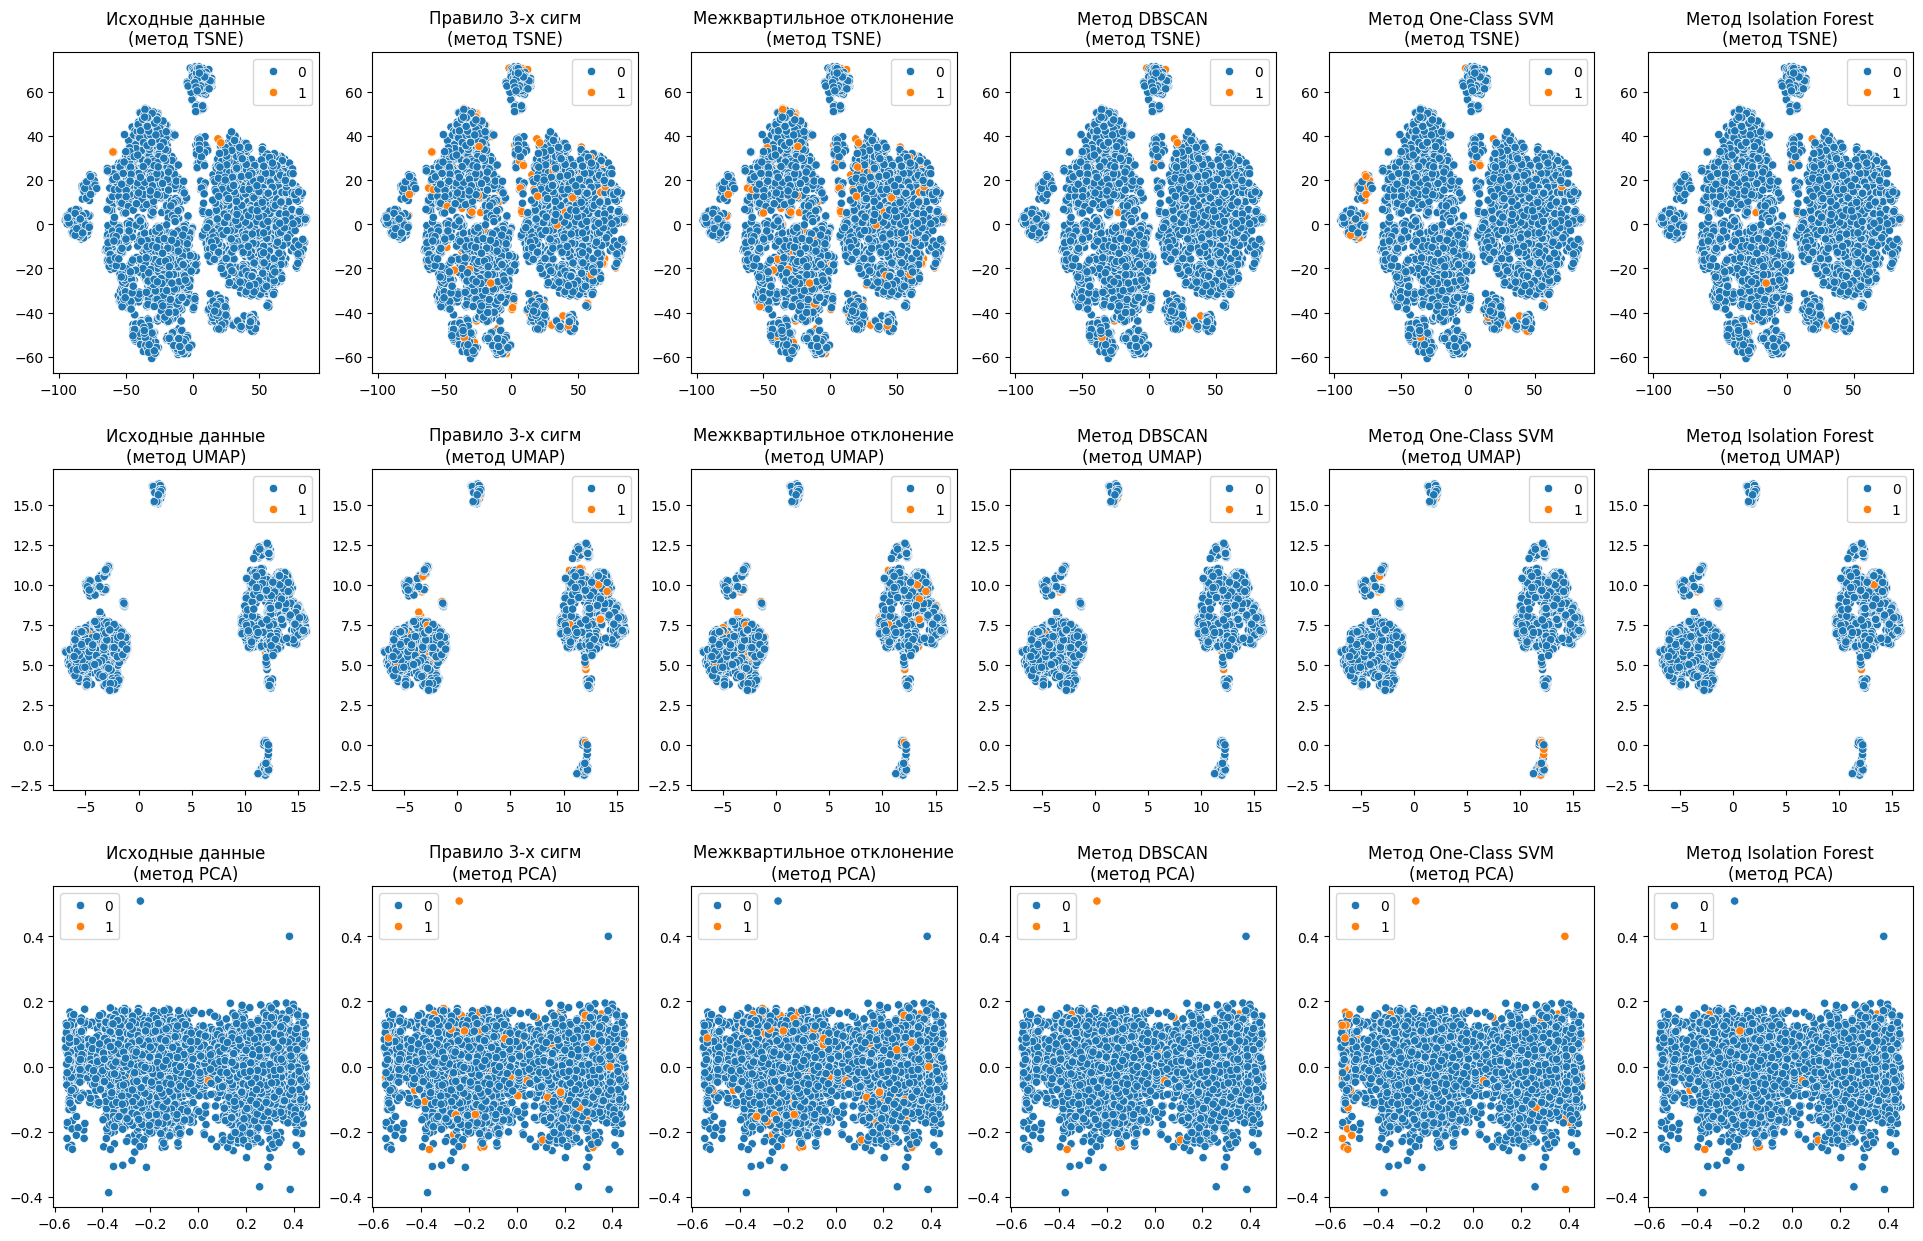

In [38]:
# Добавление исходных данных к визуализации выбросов моделей
outliers = np.vstack([Y_samples, outliers])
titles = ['Исходные данные', *titles]

# Уменьшение размерности признакового пространства методами PCA, TSNE и UMAP
pca_model = PCA(n_components=2, random_state=42).fit_transform(X_samples)
tsne_model = TSNE(n_components=2, random_state=42).fit_transform(X_samples)
umap_model = UMAP(n_components=2, random_state=42).fit_transform(X_samples)

# Определение основных объектов диаграмм
fig, axes = plt.subplots(3, 6, figsize=(24,15))

# Визуализация выбросов моделей
for i in range(len(outliers)):
    sns.scatterplot(x=tsne_model[:, 0], y=tsne_model[:, 1], ax=axes[0, i], hue=outliers[i])
    sns.scatterplot(x=umap_model[:, 0], y=umap_model[:, 1], ax=axes[1, i], hue=outliers[i])
    sns.scatterplot(x=pca_model[:, 0], y=pca_model[:, 1], ax=axes[2, i], hue=outliers[i])
    axes[0, i].set_title(titles[i] + '\n(метод TSNE)')
    axes[1, i].set_title(titles[i] + '\n(метод UMAP)')
    axes[2, i].set_title(titles[i] + '\n(метод PCA)')

# Увеличение расстояния между диаграммами
plt.subplots_adjust(hspace=0.3)

plt.show()


In [39]:
outliers = np.vstack([Y_samples, outliers])
outliers.size

39872